In [1]:
%matplotlib inline
import pandas as pd

df = pd.read_csv('data/Consumo_cerveja.csv', 
                 decimal=',', 
                 thousands='.', 
                 header=0, 
                 names=['date','median_temp','min_temp','max_temp','precip','weekend','consumption'], 
                 parse_dates=['date'], 
                 nrows=365)

Let's explore one of the more powerful features of pandas - the Split-apply-combine paradigm!

![split_apply_combine](images/split_apply_combine_example.jpg)

When exploring data, we always want to split our data into groups to discover differences between groups - groupby operations are a great way to do this in a concise and elegant way!

# Groupby

The split step is often called a groupby and should be familiar to anyone used to working in SQL - all we do in this step is define our groups. 

![Fun Fact](images/fun_fact.resized.jpeg)In Pandas, we usually define it by naming one or several columns to group by, but you can use anything as a grouper, as long as the length of the grouper is the same as the length of the data!

In [2]:
grouper = df.groupby('weekend')

In [3]:
grouper

`.groupby` returns a DataFrameGroupBy object, which "knows" how to split the data - we haven't done any actual calculations yet!

We can examine the grouper to see what it is going to do. In this example, there are two values or levels in the weekend column - 0 and 1. Our grouper has saved the indexes for each group, which we can see by inspecting the `.groups` property

In [4]:
grouper.groups

{0: Int64Index([  0,   1,   4,   5,   6,   7,   8,  11,  12,  13,
             ...
             351, 354, 355, 356, 357, 358, 361, 362, 363, 364],
            dtype='int64', length=261),
 1: Int64Index([  2,   3,   9,  10,  16,  17,  23,  24,  30,  31,
             ...
             331, 332, 338, 339, 345, 346, 352, 353, 359, 360],
            dtype='int64', length=104)}

We can get one of the groups if we want, we simply call `.get_group` with one of the keys in the `.groups` dictionary

In [5]:
grouper.get_group(1)

,date,median_temp,min_temp,max_temp,precip,weekend,consumption
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799
9,2015-01-10,26.76,22.1,34.2,0.0,1,37937
10,2015-01-11,27.62,22.2,34.8,3.4,1,36254
16,2015-01-17,28.86,22.0,35.8,0.0,1,37690
17,2015-01-18,28.26,23.4,35.6,0.0,1,30524
23,2015-01-24,23.12,19.0,29.4,13.0,1,28348
24,2015-01-25,24.40,18.1,30.0,0.0,1,31088
30,2015-01-31,21.64,18.5,24.3,0.2,1,27030
31,2015-02-01,24.16,20.6,28.0,0.0,1,32057


The grouper is also a generator, so we can use it in a for loop

In [6]:
for group, data in grouper:
    print(group)
    print('-'*30)
    print(data)

0
------------------------------
          date  median_temp  min_temp  max_temp  precip  weekend  consumption
0   2015-01-01        27.30      23.9      32.5     0.0        0        25461
1   2015-01-02        27.02      24.5      33.5     0.0        0        28972
4   2015-01-05        23.82      21.0      28.3     0.0        0        28900
5   2015-01-06        23.78      20.1      30.5    12.2        0        28218
6   2015-01-07        24.00      19.5      33.7     0.0        0        29732
7   2015-01-08        24.90      19.5      32.8    48.6        0        28397
8   2015-01-09        28.20      21.9      34.0     4.4        0        24886
11  2015-01-12        25.96      21.4      35.4     0.0        0        25743
12  2015-01-13        25.52      21.2      34.8     0.8        0        26990
13  2015-01-14        25.96      21.3      34.0     1.6        0        31825
14  2015-01-15        25.86      21.5      32.8     3.0        0        25724
15  2015-01-16        26.50    

What we normally use it for though is to apply some function to the groups. Pandas has a lot of methods available out of the box, and we can always specify our own.

For example, how many rows are there in each group?

In [7]:
grouper.size()

weekend
0    261
1    104
dtype: int64

What is the mean and std deviation for each group?

In [8]:
grouper.mean()

,median_temp,min_temp,max_temp,precip,consumption
weekend,,,,,
0,21.328199,17.567433,26.721073,5.184291,23998.222222
1,20.970769,17.195192,26.336538,5.227885,28922.721154


In [9]:
grouper.std()

,median_temp,min_temp,max_temp,precip,consumption
weekend,,,,,
0,3.165052,2.765010,4.292047,12.068447,3787.526525
1,3.218723,2.971234,4.389087,13.315211,3830.190843


Note how pandas automatically ignores our non-numerical columns!

What if we are only interested in aggregating a single column?

In [10]:
grouper.consumption.sum()

weekend
0    6263536
1    3007963
Name: consumption, dtype: int64

Sometimes we want to use several aggregations - `.agg` lets us specify any number of aggregators, including any custom functions. 

Note that for convenience, pandas let's us specify a string for the most common functions!

In [11]:
def silly_function(x):
    return sum(x ** 2)

In [12]:
grouper.agg(['std', 'mean', silly_function])

median_temp                            min_temp             \
                std       mean silly_function       std       mean   
weekend                                                              
0          3.165052  21.328199    121331.3972  2.765010  17.567433   
1          3.218723  20.970769     46803.5072  2.971234  17.195192   

                        max_temp                               precip  \
        silly_function       std       mean silly_function        std   
weekend                                                                 
0             82536.21  4.292047  26.721073      191147.74  12.068447   
1             31659.47  4.389087  26.336538       74119.98  13.315211   

                                  consumption                               
             mean silly_function          std          mean silly_function  
weekend                                                                     
0        5.184291       44883.19  3787.526525  23998.222222   154043521692  
1        5.227885       21103.77  3830.190843  28922.721154    88509522365

`.agg` also lets us specify different aggregation functions per column

In [27]:
grouper.agg({'median_temp': ['std', 'mean'], 
             'consumption': 'sum'})

median_temp            consumption
                std       mean         sum
weekend                                   
0          3.165052  21.328199     6263536
1          3.218723  20.970769     3007963

It even lets us do plotting directly on the groups

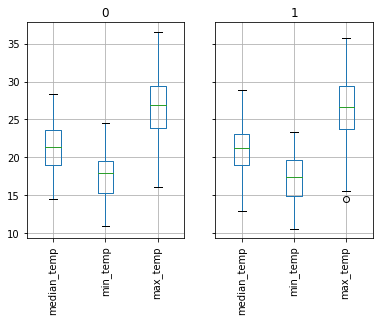

In [13]:
grouper.boxplot(rot=90, column=['median_temp', 'min_temp', 'max_temp']);

# DateTime & Resample
As mentioned when we were looking at datatypes, Pandas was built by a finance quant, and so datetimes are handled very well in the pandas library. Let's look at some of the more interesting possibilites when working with timeseries data! In order to get the most out of this functionality, we need to set a DateTime index

![Fun Fact](images/fun_fact.resized.jpeg) As of pandas 0.19.0, you no longer have to set a date as index - you can use the `on` parameter when resampling. However, it's often a good idea to have set an index, so we are still going to do it!


In [14]:
df = df.set_index('date')

In [15]:
df.head()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-01,27.30,23.9,32.5,0.0,0,25461
2015-01-02,27.02,24.5,33.5,0.0,0,28972
2015-01-03,24.82,22.4,29.9,0.0,1,30814
2015-01-04,23.98,21.5,28.6,1.2,1,29799
2015-01-05,23.82,21.0,28.3,0.0,0,28900


Having a date as index lets us do some special case indexing - Pandas will recognize dates and slice accordingly

In [16]:
df['2015-02']

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-02-01,24.16,20.6,28.0,0.0,1,32057
2015-02-02,22.48,20.7,26.5,4.5,0,24097
2015-02-03,23.16,18.0,31.1,1.6,0,31655
2015-02-04,22.12,19.9,23.7,3.2,0,24738
2015-02-05,20.28,19.1,22.9,5.6,0,19950
2015-02-06,21.06,17.9,25.4,18.4,0,22821
2015-02-07,21.86,17.3,28.7,16.7,1,28893
2015-02-08,22.76,17.1,29.5,10.4,1,29926
2015-02-09,24.00,19.3,30.7,0.0,0,24062


## Resampling

Resampling is a special case of grouping - it lets you aggregate by upsampling or downsampling your data very easily. The API is very similar to groupby, but instead of specifying a column, you specify a frequency

In [17]:
resampler = df.resample('M')

Now we can do aggregations, much like in groupby. 

For example, the mean per month:

In [18]:
resampler.mean()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-31,25.218065,21.148387,31.490323,5.038710,0.290323,28677.645161
2015-02-28,23.555000,19.935714,29.007143,9.750000,0.285714,25673.142857
2015-03-31,22.167097,19.012903,27.248387,10.732258,0.290323,25036.387097
2015-04-30,20.837333,17.783333,25.966667,3.603333,0.266667,24624.100000
2015-05-31,18.596774,15.612903,22.867742,1.635484,0.322581,22798.387097
2015-06-30,18.070000,14.073333,23.220000,0.676667,0.266667,23627.066667
2015-07-31,17.887097,14.209677,22.832258,2.100000,0.258065,22572.870968
2015-08-31,19.900000,14.887097,26.316129,1.019355,0.322581,25908.967742
2015-09-30,21.000667,16.620000,26.673333,6.723333,0.266667,25198.133333


Pandas has a wide range of offsets you can use, check the documentation for more [Offset Aliases](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries-offset-aliases)

I commonly use
- "W": Weekly
- "M" or "MS": Month end or Month start
- "Y" or "YS": Year end or Year start

Pandas has up to Nanosecond resolution, so you should be covered for most usecases!

In [19]:
df.resample('W').mean()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-04,25.780000,23.075000,31.125000,0.300000,0.500000,28761.500000
2015-01-11,25.582857,20.900000,32.614286,9.800000,0.285714,30617.714286
2015-01-18,26.702857,21.871429,34.442857,1.057143,0.285714,29776.285714
2015-01-25,24.502857,20.500000,30.657143,7.414286,0.285714,28648.142857
2015-02-01,23.611429,20.142857,27.957143,3.871429,0.285714,26103.285714
2015-02-08,21.960000,18.571429,26.828571,8.628571,0.285714,26011.428571
2015-02-15,24.817143,20.857143,30.585714,7.400000,0.285714,25401.571429
2015-02-22,23.551429,20.257143,28.614286,17.685714,0.285714,24770.142857
2015-03-01,23.477143,19.714286,29.757143,5.714286,0.285714,25854.857143


You can also put a number in front to specify every X frequencies

In [20]:
df.resample('3M').mean()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-31,25.218065,21.148387,31.490323,5.038710,0.290323,28677.645161
2015-04-30,22.155506,18.888764,27.369663,8.020225,0.280899,25097.741573
2015-07-31,18.185870,14.638043,22.970652,1.479348,0.282609,22992.619565
2015-10-31,20.934783,16.440217,26.943478,3.536957,0.293478,26264.902174
2016-01-31,22.867541,19.303279,28.016393,9.267213,0.278689,26509.852459


In [44]:
df.resample('4W').mean()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-04,25.780000,23.075000,31.125000,0.300000,0.500000,28761.500000
2015-02-01,25.100000,20.853571,31.417857,5.535714,0.285714,28786.357143
2015-03-01,23.451429,19.850000,28.946429,9.857143,0.285714,25509.500000
2015-03-29,22.152857,19.003571,27.267857,11.075000,0.285714,24924.214286
2015-04-26,21.278571,18.085714,26.453571,4.560714,0.285714,25236.964286
2015-05-24,18.397857,15.517857,22.728571,1.289286,0.285714,22113.285714
2015-06-21,18.891429,15.228571,23.707143,1.075000,0.285714,24059.857143
2015-07-19,17.810714,14.150000,22.525000,1.832143,0.285714,23298.357143
2015-08-16,19.157857,14.232143,25.460714,0.664286,0.285714,24507.714286


Pandas also lets us upsample data

For example, let's say we have the monthly mean:

In [21]:
monthly_df = df.resample('M').mean()

We now want to upsample to a daily resolution - we can then specify we want to fill forward the missing values

In [22]:
monthly_df.resample('D').ffill()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-31,25.218065,21.148387,31.490323,5.03871,0.290323,28677.645161
2015-02-01,25.218065,21.148387,31.490323,5.03871,0.290323,28677.645161
2015-02-02,25.218065,21.148387,31.490323,5.03871,0.290323,28677.645161
2015-02-03,25.218065,21.148387,31.490323,5.03871,0.290323,28677.645161
2015-02-04,25.218065,21.148387,31.490323,5.03871,0.290323,28677.645161
2015-02-05,25.218065,21.148387,31.490323,5.03871,0.290323,28677.645161
2015-02-06,25.218065,21.148387,31.490323,5.03871,0.290323,28677.645161
2015-02-07,25.218065,21.148387,31.490323,5.03871,0.290323,28677.645161
2015-02-08,25.218065,21.148387,31.490323,5.03871,0.290323,28677.645161


# Rolling

Rolling has a similar API to groupby and resample, but works by aggregating over a rolling window. It's often used to smooth out jagged timeseries to see larger trends.

It works in the same way as we've seen before, but takes a window parameter instead - let's do a 7 day rolling mean

In [23]:
rolling = df.rolling(7)

In [24]:
rolling.mean()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,24.960000,21.842857,31.000000,1.914286,0.285714,28842.285714
2015-01-08,24.617143,21.214286,31.042857,8.857143,0.285714,29261.714286
2015-01-09,24.785714,20.842857,31.114286,9.485714,0.285714,28678.000000


Note that the first 6 rows will be NaN, as there isn't enough information to compute the rolling mean

We can also combine resampling and rolling to get a rolling 6 month mean

In [25]:
rolling_month = df.resample('M').mean().rolling(6)

In [26]:
rolling_month.mean()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-31,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,21.407378,17.927762,26.633377,5.239409,0.287046,25072.788146
2015-07-31,20.185550,16.771311,25.190366,4.749624,0.281669,24055.325781
2015-08-31,19.576384,15.929875,24.741864,3.294516,0.287814,24094.629928
2015-09-30,19.381978,15.531057,24.646022,2.626362,0.283871,24121.587634


Or combine groupby and resample to get mean monthly results for each group

In [27]:
df.groupby('weekend').resample('M').mean()

median_temp   min_temp   max_temp     precip  weekend  \
weekend date                                                                
0       2015-01-31    25.104545  21.200000  31.527273   6.290909      0.0   
        2015-02-28    23.575000  20.030000  28.860000  11.425000      0.0   
        2015-03-31    22.310909  18.950000  27.659091   8.790909      0.0   
        2015-04-30    20.645455  17.704545  25.709091   4.877273      0.0   
        2015-05-31    18.582857  16.047619  22.495238   2.147619      0.0   
        2015-06-30    17.909091  14.181818  22.818182   0.922727      0.0   
        2015-07-31    18.086087  14.230435  23.243478   1.039130      0.0   
        2015-08-31    19.760000  15.042857  25.676190   1.504762      0.0   
        2015-09-30    21.580000  16.768182  27.536364   6.422727      0.0   
        2015-10-31    22.632727  18.050000  29.109091   3.022727      0.0   
        2015-11-30    22.436190  19.038095  27.419048   8.057143      0.0   
        2015-12-31    23.426087  19.726087  28.656522   8.156522      0.0   
1       2015-01-31    25.495556  21.022222  31.400000   1.977778      1.0   
        2015-02-28    23.505000  19.700000  29.375000   5.562500      1.0   
        2015-03-31    21.815556  19.166667  26.244444  15.477778      1.0   
        2015-04-30    21.365000  18.000000  26.675000   0.100000      1.0   
        2015-05-31    18.626000  14.700000  23.650000   0.560000      1.0   
        2015-06-30    18.512500  13.775000  24.325000   0.000000      1.0   
        2015-07-31    17.315000  14.150000  21.650000   5.150000      1.0   
        2015-08-31    20.194000  14.560000  27.660000   0.000000      1.0   
        2015-09-30    19.407500  16.212500  24.300000   7.550000      1.0   
        2015-10-31    20.128889  17.255556  24.711111   2.844444      1.0   
        2015-11-30    21.628889  18.411111  26.155556   8.666667      1.0   
        2015-12-31    23.787500  19.787500  29.837500  16.312500      1.0   

                     consumption  
weekend date                      
0       2015-01-31  27251.045455  
        2015-02-28  24226.900000  
        2015-03-31  23766.636364  
        2015-04-30  22601.636364  
        2015-05-31  21030.238095  
        2015-06-30  21857.363636  
        2015-07-31  21329.260870  
        2015-08-31  23672.333333  
        2015-09-30  24506.045455  
        2015-10-31  27035.818182  
        2015-11-30  24472.904762  
        2015-12-31  26144.869565  
1       2015-01-31  32164.888889  
        2015-02-28  29288.750000  
        2015-03-31  28140.222222  
        2015-04-30  30185.875000  
        2015-05-31  26511.500000  
        2015-06-30  28493.750000  
        2015-07-31  26148.250000  
        2015-08-31  30605.900000  
        2015-09-30  27101.375000  
        2015-10-31  29162.333333  
        2015-11-30  28990.555556  
        2015-12-31  30115.375000